More PyTorch tutorials can be found at [https://pytorch.org/tutorials/](https://pytorch.org/tutorials/)

# Import pytorch libraries

In [1]:
import math
import numpy as np

import torch
from torch import nn, optim, cuda
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms


use_gpu=False
if cuda.is_available():
    # check if GPU is available
    print(cuda.get_device_properties(0))

# for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Steps to create a Neural Networks with Pytorch

1. Define dataset, data loader and transformations
1. Define a Neural Network (forward propagation)
1. Define optimizer and criterion
1. Train the model (back propagation)
1. Evaluate the model
1. Make prediction

# Step 1: Define dataset, data loader and transformation

<!-- PyTorch gives use the freedom to pretty much do anything with the Dataset class so long as you override two of the subclass functions:
* the __len__ function which returns the size of the dataset, and
* the __getitem__ function which returns a sample from the dataset given an index.

However, in our case we can simply construct a TensorDataset with two items: the feature data and the target where the feature data is the matrix of pixel 1 - pixel 784 and the target is the digit of the image. -->


While the Dataset class is a nice way of containing data systematically, it seems that in a training loop, we will need to index or slice the dataset's samples list. This is no better than what we would do for a typical list or NumPy matrix. Rather than going down that route, PyTorch supplies another utility function called the DataLoader which acts as a data feeder for a Dataset object.


In order to construct the data loader we will need to provide two parameters: **batch_size** which indicates how many samples we want to use to train  the model in a batch, and **shuflle**, suggesting if we want to shuffle the data before sending it to the network. 

Typically we would want to set batch_size as $2^n$ e.g. 128, 256, 512, and set `shuffle` as `True` for traning data and `False` for validation and test data (you can take a moment to think why?)



### Download Datasets

In [2]:
# preparing transforming functions
# data_tf=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5],[0.5])])
data_tf=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# download datasets
train_dataset = datasets.MNIST(root='../data', train=True, transform=data_tf, download=True)
test_dataset = datasets.MNIST(root='../data', train=False, transform=data_tf, download=True)


### Load Datasets

In [3]:
# data loader
batch_size=64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Display sample pictures from the dataset

<!-- row_num=8 # if batch_size=64, plot matrix as 8x8
column_num=int(batch_size/row_num)

#---create a grid figure----
fig, axes = plt.subplots(row_num, column_num, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

#---iterate and plot figures---
for i, ax in enumerate(axes.flat):
    ax.imshow(test_dataset.data[i], cmap='Greys', interpolation='nearest')
    ax.text(0.1, 0.1, test_dataset.targets[i].numpy(), transform=ax.transAxes, color='green')
 -->


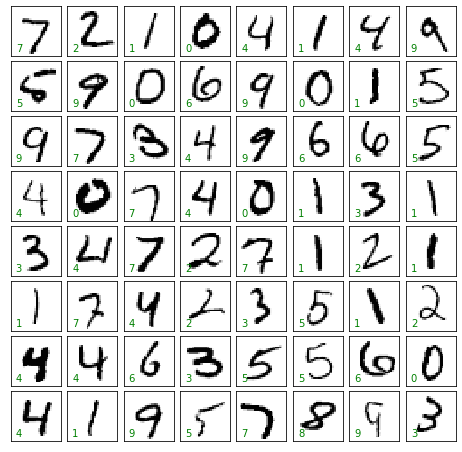

In [4]:
sample_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
data=iter(sample_loader)
samples,sample_labels=data.next()

row_num=8 # if batch_size=64, plot matrix as 8x8
column_num=int(batch_size/row_num)


fig, axes = plt.subplots(row_num, column_num, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(samples[i][0], cmap='Greys', interpolation='nearest')
    ax.text(0.1, 0.1, sample_labels[i].numpy(), transform=ax.transAxes, color='green')

# Step 2: Define a Deep Neural Networks

<!-- ![nn](images/neural_network_example.png)

The neural network architectures in Pytorch can be defined in a class which inherits the properties from the base class from **nn** package called Module. This inheritance from the nn.Module class allows us to implement, access, and call a number of methods easily. We can define all the layers inside the constructor of the class, and the forward propagation steps inside the forward function.

We will define a simple Multilayer Perceptron with the following architecture:

* Input layer
```Python
nn.Linear(28 * 28, 512)
```
    * Layer type: nn.Linear(), which refers to a fully connection layer
    * Input size: 28*28, corresponding to the size of input data.
    * Output size: 512, the number of "neurons".
    
* Hidden layer
```
nn.Linear(512, 256)
```

    * Layer type: nn.Linear()
    * Input size: 512, output size of the previous layer(input layer).
    * Output size: 256, the number of "neurons" in this layer.
    
* Output layer
```
nn.Linear(256, 10)
```

    * Layer type: nn.Linear()
    * Input size: 256, output size of the previous layer(hidden layer).
    * Output size: 10, the number of classes we need to predict.

* Activation functions
Each linear layer's output needs to go through an activation function to "activate" it. We will get started with **F.sigmoid()** but can try F.relu() or others later.

The best practice is to name each layer and initialize them in the **__init__()** function as named building blocks and put the building blocks together in the **forward()** function which defines how the data actually flows in the network. In our case, each layer simply takes the output of the previous layer and perform transformations the generate outputs in sequence. -->

![LeNet](images/lenet.png)
LeNet. Original image published in [LeCun et al., 1998]

[LeCun et al., 1998]: https://ieeexplore.ieee.org/document/726791/

A **convolution neural network (CNN)** performs the operation of **convolution** which adds elements of each image pixel to its local neighbor, weighted by a matrix or a small matrix, which helps to extract local features (e.g. sharpness, blurness, and edge) in an image. A major difference between a convolution layer and a **fully connected (FC)** layer is each element or neuron in a convolution layer is only connected to its neighbors; however, in a FC layer, each element is connected to all elements from the previous layer.

![Convolution](images/convolution-example.png)

Convolution example. Picture from https://towardsdatascience.com/simple-introduction-to-convolutional-neural-networks-cdf8d3077bac.

Another important operation is **pooling**. Pooling is used to reduce the dimension of data (tenor) in the neural network. A frequently used pooling method is called "max pool" which first divide each tensor into smaller subsets, and get the maximum value of each subset that is used to form a new tensor with smaller dimension.

![Maxpool](images/maxpool-example.png)

Max pool example. Picture from https://analyticsindiamag.com/max-pooling-in-convolutional-neural-network-and-its-features/

A **dropout** layer randomly "drops" a network element or set its weight to zero. The purpose is to avoid generating a too "complicated" network which tends to overfit the data. Overfiting the data will decrease the generalization ability of the neural network meaning the model will perform poorly given unsean validation or test data.

A **deep neural network (DNN)**, such as CNN, is a composition of mulitple types of layers such as convlution layers, pooling layers, dropout layers, fully connected layers, etc. The final output layer can be a `softmax` layer which yeilds a result or label with the maximum prediciton probability. 


In [6]:
class CNNExample(nn.Module):
    """
    from: https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html
    """
    def __init__(self):
        super(CNNExample, self).__init__()
        
        # First 2D convolutional layer, taking in 1 input channel (grayscale image),
        # outputting 32 convolutional features, with a square kernel size of 3
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        # Second 2D convolutional layer, taking in the 32 input layers,
        # outputting 64 convolutional features, with a square kernel size of 3
        self.conv2 = nn.Conv2d(32, 64, 3, 1)

        # Designed to ensure that adjacent pixels are either all 0s or all active
        # with an input probability
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)

        # First fully connected layer
        self.fc1 = nn.Linear(9216, 128)
        # Second fully connected layer that outputs our 10 labels
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.conv1(x) # conv layer 1
        x = F.relu(x) # activation function
        x = self.conv2(x) # conv layer 2
        x = F.max_pool2d(x, 2) # pool layer
        x = self.dropout1(x) # dropout layer 1
        x = torch.flatten(x, 1) # flatten layer 
        x = self.fc1(x) # full connection layer 1
        x = F.relu(x) # activation function
        x = self.dropout2(x) # dropout layer 2
        x = self.fc2(x) # full connection layer 2
        output = F.log_softmax(x, dim=1) # output use softmax function
        return output

## Define the model for training
The following code defines a neural network. It will be used in later coding.

```Python
# define model
model = BatchNet(28*28, 300, 100, 10)
if cuda.is_available(): 
    #if GPU is available
    model=model.cuda()
```

# Step 3: Define optimizer and criterion

Optimizer is used to perform the gradient descent process. There are several optimizers avaialble such as SGD( Stochastic Gradient Descent), Adam, Adagrad, etc. The tricky part is how to set the right size of learning rate (`learning_rate`) which could have a huge impact on the final result. Learning rate is step size when training the neural network. A larger step size trains quicker but may "miss" the optimal solution. For example, let's simply use 0.1 as the starting point.

Criterion will be used to calculate the cost (or loss) so we can use the cost to do back propagation and update the weights we want to train. In our case, we will use `nn.CrossEntropyLoss()` since we are working on a multiclassfication problem.

```Python
#---optimizer for training the neural network---
learning_rate=1e-1

# use Adam optimizer
optimizer=optim.Adam(model.parameters(), lr=learning_rate)

#---criterion is the cost or error function---
criterion=nn.CrossEntropyLoss()
```

# Step 4 train the model (back propagation)

Training the model is an iterative process which contains many epoches. For each epoch we will repeatly load batches of data, perform forward propagation, calculate cost, perform back propagation using the optimizer.

**Epoch** is how many times one wants to train the neural network. Each epoch will load and train all the training data through the neural network. After each epoch, the cost (error) function tends to get lower errors. Larger number of epoch means more rounds of training and may further lower the error of training but will take longer time. However, you may notice in the experiment that a very large number of epoch may not be necessary if the training error is "acceptable" after a lower number of rounds. 

In [7]:
##########training############
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        train_loss=0
        for data in train_loader:
            img, label = data
            #img = img.view(img.size(0),-1)
            if use_gpu and cuda.is_available(): #if use_gpu switch is on
                img=Variable(img).cuda()
                label=Variable(label).cuda()
            else:
                img=Variable(img)
                label=Variable(label)
            ##forward training
            out = model(img)
            loss = criterion(out, label)
            #loss=F.nll_loss(out,label)
            train_loss += loss.data*label.size(0)
            #print(loss.data)
            #print(label.size(0))
            train_loss+=loss.item()
            # backward propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        #scheduler.step()
        if (epoch+1)%(num_epochs/10) ==0:
            print(f'Epoch {epoch+1}/{num_epochs}, eval_loss={train_loss/(len(test_dataset))}')
    return model


# Step 5: Test the model

We will use the trained model to make predictions on the validation dataset and compare the predictions against the actual targets. Dataloader will be used to iterate the validation dataset as well.

In [8]:
##########testing##########
def test_model(model, criterion, test_loader):
    eval_loss=0
    eval_acc=0
    #use evaluation model
    model.eval()
    for data in test_loader:
        img, label = data
        #img = img.view(img.size(0),-1)
        if use_gpu and cuda.is_available(): #if use_gpu switch is on
            img=Variable(img).cuda()
            label=Variable(label).cuda()
        else:
            img=Variable(img)
            label=Variable(label)
        out = model(img)
        loss = criterion(out, label)
        eval_loss += loss.data*label.size(0)
        _, pred = torch.max(out, 1) #???
        num_correct = (pred==label).sum()
        eval_acc += num_correct.data
        #print('pred: {}, label: {}, num_correct: {}'.format(pred, label, num_correct))
    loss=eval_loss/(len(test_dataset))
    accuracy=eval_acc*1.0/(len(test_dataset))
    print(f'Test Loss: {loss}, Acc: {accuracy}')
    return loss, accuracy


# Step 6: Putting Together and Action

In [9]:
%%time

#gpu switch on/off
use_gpu=False

# # define model
# model=CNN()
model=CNNExample()
# model = CNN2()
# print(model)

if use_gpu and cuda.is_available():
    print(f'using GPU: {cuda.get_device_properties(0)}')
    model=model.cuda()
else:
    print('using CPU')
    model=model.cpu()
    
# learning rate
learning_rate=1e-1
#learning_rate=1
    
#---optimizer for training the neural network---
# use Adadelta optimizer: https://pytorch.org/docs/stable/generated/torch.optim.Adadelta.html
optimizer=optim.Adadelta(model.parameters(), lr=learning_rate)
##---uncomment the following lines to try out different optimizers---
#optimizer=optim.Adagrad(model.parameters(), lr=learning_rate)
#optimizer=optim.Adam(model.parameters(), lr=learning_rate)
#optimizer=optim.SGD(model.parameters(), lr=learning_rate)


#---criterion is the cost or error function---
criterion=nn.CrossEntropyLoss()
#criterion=nn.NLLLoss()

# #---scheduler---
# scheduler = StepLR(optimizer, step_size=1, gamma=0.7) # need by NLLLoss

# set number of epochs
num_epochs=10

# train model
model = train_model(model, train_loader, criterion, optimizer, num_epochs)
loss, accuracy=test_model(model, criterion, test_loader)


using CPU
Epoch 1/10, eval_loss=1.8334380388259888
Epoch 2/10, eval_loss=0.6913309693336487
Epoch 3/10, eval_loss=0.5155202150344849
Epoch 4/10, eval_loss=0.4438762664794922
Epoch 5/10, eval_loss=0.3854425847530365
Epoch 6/10, eval_loss=0.3471304774284363
Epoch 7/10, eval_loss=0.3291970491409302
Epoch 8/10, eval_loss=0.30294349789619446
Epoch 9/10, eval_loss=0.2859419882297516
Epoch 10/10, eval_loss=0.2647589147090912
Test Loss: 0.03561069816350937, Acc: 0.9898999929428101
CPU times: user 9min 29s, sys: 2min 17s, total: 11min 46s
Wall time: 3min 56s


---

### Sample results:


* Macbook Pro M1 CPU:

learning rate|number of epocs|criterion|optimizer
---|---|---|---
0.1|20|cross entropy|Adadelta


    using CPU
    Epoch 2/20, eval_loss=0.7517828941345215
    Epoch 4/20, eval_loss=0.48508456349372864
    Epoch 6/20, eval_loss=0.3670792579650879
    Epoch 8/20, eval_loss=0.31273218989372253
    Epoch 10/20, eval_loss=0.2832340598106384
    Epoch 12/20, eval_loss=0.23937365412712097
    Epoch 14/20, eval_loss=0.2233337163925171
    Epoch 16/20, eval_loss=0.2035352885723114
    Epoch 18/20, eval_loss=0.1921214461326599
    Epoch 20/20, eval_loss=0.179552361369133
    Test Loss: 0.03176043927669525, Acc: 0.9908999800682068
    CPU times: user 18min 9s, sys: 4min 38s, total: 22min 48s
    Wall time: 7min 2s

---

* STEM Cloud GPU-PC3 CPU:

<!-- learning rate: 0.1; number of epocs: 20; criterion: cross entropy; optimizer: Adadelta -->

learning rate|number of epocs|criterion|optimizer
---|---|---|---
0.1|20|cross entropy|Adadelta

```
using CPU
Epoch 2/20, eval_loss=0.7576344013214111
Epoch 4/20, eval_loss=0.44593003392219543
Epoch 6/20, eval_loss=0.3518705666065216
Epoch 8/20, eval_loss=0.30115020275115967
Epoch 10/20, eval_loss=0.2703513503074646
Epoch 12/20, eval_loss=0.2431371510028839
Epoch 14/20, eval_loss=0.2065913826227188
Epoch 16/20, eval_loss=0.194166898727417
Epoch 18/20, eval_loss=0.19129399955272675
Epoch 20/20, eval_loss=0.17096801102161407
Test Loss: 0.04144658148288727, Acc: 0.9889000058174133
CPU times: user 29min 8s, sys: 1min 9s, total: 30min 18s
Wall time: 8min 33s
```

learning rate|number of epocs|criterion|optimizer
---|---|---|---
0.1|40|cross entropy|Adadelta

```
using CPU
Epoch 4/40, eval_loss=0.4648208022117615
Epoch 8/40, eval_loss=0.3049250841140747
Epoch 12/40, eval_loss=0.24013623595237732
Epoch 16/40, eval_loss=0.205618217587471
Epoch 20/40, eval_loss=0.16693182289600372
Epoch 24/40, eval_loss=0.14103581011295319
Epoch 28/40, eval_loss=0.12344837933778763
Epoch 32/40, eval_loss=0.103425033390522
Epoch 36/40, eval_loss=0.09953168779611588
Epoch 40/40, eval_loss=0.09446790814399719
Test Loss: 0.03882128745317459, Acc: 0.9900000095367432
CPU times: user 57min 14s, sys: 3.23 s, total: 57min 17s
Wall time: 16min 15s
```

---

* STEM Cloud GPU-PC3 GPU:

<!-- learning rate: 0.1; number of epocs: 20; criterion: cross entropy; optimizer: Adadelta -->

learning rate|number of epocs|criterion|optimizer
---|---|---|---
0.1|20|cross entropy|Adadelta

```
using GPU: _CudaDeviceProperties(name='Quadro RTX 4000', major=7, minor=5, total_memory=7979MB, multi_processor_count=36)
Epoch 2/20, eval_loss=0.6966244578361511
Epoch 4/20, eval_loss=0.4318397343158722
Epoch 6/20, eval_loss=0.33928409218788147
Epoch 8/20, eval_loss=0.2915371060371399
Epoch 10/20, eval_loss=0.25787410140037537
Epoch 12/20, eval_loss=0.2114899903535843
Epoch 14/20, eval_loss=0.20517906546592712
Epoch 16/20, eval_loss=0.18708714842796326
Epoch 18/20, eval_loss=0.1714428961277008
Epoch 20/20, eval_loss=0.16019845008850098
Test Loss: 0.031663019210100174, Acc: 0.989799976348877
CPU times: user 2min 36s, sys: 760 ms, total: 2min 37s
Wall time: 2min 37s
```

<!-- learning rate: 0.1; number of epocs: 40; criterion: cross entropy; optimizer: Adadelta -->

learning rate|number of epocs|criterion|optimizer
---|---|---|---
0.1|40|cross entropy|Adadelta

```
using GPU: _CudaDeviceProperties(name='Quadro RTX 4000', major=7, minor=5, total_memory=7979MB, multi_processor_count=36)
Epoch 4/40, eval_loss=0.4653308093547821
Epoch 8/40, eval_loss=0.3177127242088318
Epoch 12/40, eval_loss=0.23504582047462463
Epoch 16/40, eval_loss=0.19485096633434296
Epoch 20/40, eval_loss=0.18018969893455505
Epoch 24/40, eval_loss=0.14676715433597565
Epoch 28/40, eval_loss=0.13056157529354095
Epoch 32/40, eval_loss=0.12738990783691406
Epoch 36/40, eval_loss=0.10587641596794128
Epoch 40/40, eval_loss=0.09343577921390533
Test Loss: 0.038114871829748154, Acc: 0.9907999634742737
CPU times: user 5min 9s, sys: 655 ms, total: 5min 10s
Wall time: 5min 11s
```

<!-- * Google Colab CPU:
    * learning rate: 0.1; number of epocs: 20; criterion: cross entropy; optimizer: Adam
 -->


# Step 7: make prediction

This step is similar to the validation step except that we are not comparing the predictions as there's no ground truth of target to compare with.

Predition Errors: 0 of 64 | Prediction accuracy: 100.0%


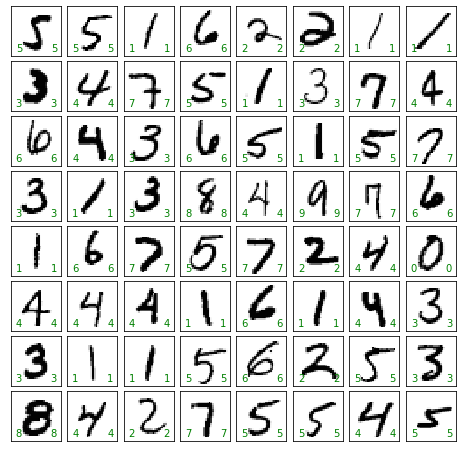

In [11]:
sample_size=batch_size
# let shuffle be True to load random images each time
sample_loader = DataLoader(test_dataset, batch_size=sample_size, shuffle=True) 
data=iter(sample_loader)
samples,sample_labels=data.next()

row_num=8 # if batch_size=64, plot matrix as 8x8
column_num=int(batch_size/row_num)

# output = model(samples.view(samples.size(0),-1))
output=model(samples)
_, pred = torch.max(output, 1)

# print(sample_labels)
# print(pred)

fig, axes = plt.subplots(row_num, column_num, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

error = 0 # prediction error
for i, ax in enumerate(axes.flat):
    ax.imshow(samples[i][0], cmap='Greys', interpolation='nearest')
    ax.text(0.1, 0.1, sample_labels[i].numpy(), transform=ax.transAxes, color='green')
    if sample_labels[i].numpy()==pred[i].numpy():
        color_pred='green'
    else:
        color_pred='red'
        error+=1
    ax.text(0.8, 0.1, pred[i].numpy(), transform=ax.transAxes, color=color_pred)

accuracy_predict=(1-error*1.0/sample_size)*100
print(f'Predition Errors: {error} of {sample_size} | Prediction accuracy: {accuracy_predict}%')


<!--
```Python
model.eval()
sample_size=batch_size # take same size sample as batch size
sample_list=np.random.randint(len(test_loader), size=(sample_size))
# print(f'sample list: {sample_list}')

row_num=8 # if batch_size=64, plot matrix as 8x8
column_num=int(sample_size/row_num)

image_list=[test_dataset.data[i] for i in sample_list]
label_list=[test_dataset.targets[i].numpy() for i in sample_list]
image_tensor_list=torch.stack(tmp,0)
image_tensor_list=image_tensor_list.view(ttmp.size(0),-1).float()#reshape and transfer to float data for learning

output = model(image_tensor_list)
_, pred = torch.max(output, 1)

print(label_list)
print(pred)

#---create a grid figure----
fig, axes = plt.subplots(row_num, column_num, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

#---iterate and plot figures---
error=0

for i, ax in enumerate(axes.flat):
    image = image_list[i]
    label_original = label_list[i]
    ax.imshow(image, cmap='Greys', interpolation='nearest') # show image
    ax.text(0.1, 0.1, label_original, transform=ax.transAxes, color='green') # show correct label
    # if prediction is correct the color is green; o.w. the predition label is red
    if label_original==pred[i].numpy(): 
        color_pred='green'
    else:
        color_pred='red'
        error+=1
    ax.text(0.8, 0.1, pred[i].numpy(), transform=ax.transAxes, color=color_pred)

accuracy_predict=1-error*1.0/sample_size
print(f'Prediction accuracy: {accuracy_predict}')
```
-->

<font style="font-size:30px" color="red">Your Turn</font>

1. Try different values for num_epochs.

1. Try different values for batch_size such as 64, 128, 256, 512.

1. Try different learning rate (0.0001, 0.001, 0.1). What is your observation of the evalation loss (`eval_loss`) in training?

1. `relu()` was used as the activation function for the MLP model we implemented. Try other activation functions such as `sigmoid()` and `tanh()`. What is your observation in training? (You may want to refer to the [PyTorch Functional](https://pytorch.org/docs/stable/nn.functional.html) for more details.)
    
1. Try different optimizers such as `SGD` and `Adagrad`.  What is your observation in training? (Refer to [PyTorch Optimizer](https://pytorch.org/docs/stable/optim.html))

1. Try to add/ remove hiden layers, as well as different number of neurons and report your validation results.  What is your observation in training?

1. What can you think of if we want to improve the current model?


<!-- # Assignments: -->


<!-- 1. Can you implment the following functions for model training, evaluation and prediction so we can reuse them when we need to test different things afterwards without having to replicate the codes every time.

```python

def train_model(nn_model, train_loader, optimizer, criterion, n_epoch):
    # YOUR IMPLEMENTATION
    return nn_model

def eval_model(nn_model, val_loader):
    # YOUR IMPLEMENTATION
    return calculated_accuracy


def predict(nn_model, test_loader):
    # YOUR IMPLEMENTATION
    return predictions

```


2. F.sigmoid() was used as the activation function for the MLP model we implemented. Can you try other activation functions such as F.relu() and F.tanh()? You may want to refer to the [PyTorch Functional](https://pytorch.org/docs/stable/nn.functional.html) for more details. Use the train_model(), eval_model() functions you implmented so you don't have to repeat the same codes.

3. Can you add a dropout layer between input and the hidden layer, and another one between the hidden layer and the output layer?

4. Try to add/ remove hiden layers, as well as different number of neurons and report your validation results.

5. Try different learning rate (0.0001, 0.001, 0.01, 0.1). What is your observation?

6. Try different values for batch_size(64, 128, 256, 512).

7. Try different values for n_epochs.

8. What can you think of if we want to improve the current model?
 -->

